In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

In [2]:
preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
print(preDouble)

\\iobsdc01\SharedDocs\SEER_MEDICARE\SEER_MEDICARE_STAGING


In [3]:
import pickle
fileObject = open('pure_control_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices = list(b)


In [4]:
import pickle
fileObject = open('pure_treatment_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices = list(b)


In [5]:
df = pd.read_pickle('dfpedsfFirsts.pickle')


In [6]:
dg = pd.read_pickle('pure_goodindices_medpar.pickle')

In [7]:
d_t_c = dict(zip(treatmentindices, controlindices))
d_c_t = dict(zip(controlindices, treatmentindices))

In [8]:
dgtreatment = dg[dg.patient_id.isin(treatmentindices)].copy()

dgcontrol = dg[dg.patient_id.isin(controlindices)].copy()

In [9]:

df = df.set_index('patient_id',drop=False)

In [10]:
goodindices = controlindices + treatmentindices
print(len(goodindices),len(controlindices),len(treatmentindices))

1662 831 831


In [11]:
df_all_good_indices = df.loc[goodindices].copy()

In [12]:
del df

In [13]:

monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}


df_all_good_indices['month1'] = df_all_good_indices['modx1'].replace(monthdict)

# <font color="#E56717">We need to only keep claims for which the date of admission is later in time than the cancer diagnosis date</font>

## Let's limit it just to prostate

In [14]:
#bad_month_indices_filter = df_all_good_indices['month1'].isnull()
prostate_filter = df_all_good_indices['site1'].str.contains('prostate',case=False,na=False)
to_drop = list(df_all_good_indices[~prostate_filter].site1.index)
print(to_drop)

['4482160083', '2215176050', '8859072472', '2310153070', '8802026371', '8757024520', '8831097343', '8878004314', '8827010107', '4408106073', '8797097489', '8835013250', '4339013024', '4304141320', '4326238080', '4269060013', '8848090384', '4268053014', '8797035478', '8841081424', '8868081313', '4339033024', '4222034004', '8735038409', '8716025459', '4462162024', '8821066343', '8858012304', '8845030491', '8841000365', '8888027441', '4313295000', '8825058106', '8888086461', '4473112043', '8714009560', '8870085471', '8819038335', '8885077334', '8865081345', '8815026310', '8889005430', '4454195034', '4247072024', '8851092441', '8897051314', '4295048060', '8852000315', '8875067360', '4315229060']


In [15]:
drop_set = set(to_drop)
t_set = set(d_t_c.keys())

lose_set = t_set.intersection(drop_set)
print(len(lose_set))


25


In [16]:
for i in list(lose_set):
    del d_t_c[i]

In [17]:
goodtreatmentindices = d_t_c.keys()
goodcontrolindices = d_t_c.values()
print(len(goodtreatmentindices), len(goodcontrolindices))

806 806


# Just including the prostate cancer patients now

In [18]:

df_all_good_indices = df_all_good_indices.loc[list(goodcontrolindices) + list(goodtreatmentindices)]

In [20]:
df_all_good_indices.month1.value_counts()

08    152
02    150
06    146
03    146
01    140
04    136
10    136
05    134
07    134
11    130
09    106
12     96
Name: month1, dtype: int64

In [21]:
df_all_good_indices.month1.iloc[0]

'05'

In [22]:
df_all_good_indices['newmonth1'] = df_all_good_indices.month1.fillna('01').copy()

In [23]:

df_all_good_indices['yrdx_plus_modx'] = df_all_good_indices.yrdx1.astype('str') + df_all_good_indices.newmonth1.astype('str')


df_all_good_indices['yrdx_plus_modx'] = pd.to_datetime(df_all_good_indices['yrdx_plus_modx'], 
                                                      format='%Y%m')

In [46]:
dg = dg.set_index('patient_id',drop=False)

In [50]:
dgtreatment = dg[dg.patient_id.isin(goodtreatmentindices) & prostate_filter].copy()

dgcontrol = dg[dg.patient_id.isin(goodcontrolindices) & prostate_filter].copy()

In [51]:
dgtreatment.shape

(1037, 171)

In [52]:
dgcontrol.shape

(1628, 171)

In [53]:
dg.shape

(2917, 171)

In [54]:
dgtreatment['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgtreatment['site1'] = df_all_good_indices['site1']

In [55]:
dgtreatment.shape

(1037, 173)

In [56]:
dgcontrol['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dgcontrol['site1'] = df_all_good_indices['site1']

In [57]:
dgcontrol.shape

(1628, 173)

In [58]:
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date.astype('str').str.replace('\.0','')
dgtreatment['medpar_admission_date_new'] = dgtreatment.medpar_admission_date_new.str.rjust(8,'0')

In [59]:
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date.astype('str').str.replace('\.0','')
dgcontrol['medpar_admission_date_new'] = dgcontrol.medpar_admission_date_new.str.rjust(8,'0')

In [60]:
dgtreatment['medpar_admission_date_new'] = pd.to_datetime(dgtreatment['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

In [61]:
dgcontrol['medpar_admission_date_new'] = pd.to_datetime(dgcontrol['medpar_admission_date_new'], 
                                                      format='%m%d%Y').copy()

In [62]:
df_all_good_indices.shape

(1612, 499)

In [63]:
dgtreatment.head()

,registry,patient_id,age,stdstate,std_cnty,admday,dschgsta,ghopd,ppsind,provcode,...,outclrcde,primpayr,esrdcond,admsrce,admtype,admdxcde,deathadm,yrdx_plus_modx,site1,medpar_admission_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
8876036350,88,8876036350,77,5,430,2,A,NaN,2,NaN,...,0,NaN,0,7,2,6824,0,2006-05-01,Prostate gland,2006-04-23
8860084330,88,8860084330,70,5,430,5,A,NaN,2,NaN,...,0,NaN,0,1,3,4139,0,2006-01-01,Prostate gland,2006-12-06
8881015430,88,8881015430,75,5,460,2,A,NaN,2,NaN,...,0,NaN,0,7,1,35800,0,2010-02-01,Prostate gland,2006-10-08
8881015430,88,8881015430,75,5,460,5,A,NaN,2,NaN,...,2,NaN,0,7,1,51881,0,2010-02-01,Prostate gland,2006-10-25
8881015430,88,8881015430,75,5,460,7,A,NaN,2,NaN,...,0,NaN,0,1,2,35801,0,2010-02-01,Prostate gland,2006-12-15


In [64]:
dgcontrol.head()

,registry,patient_id,age,stdstate,std_cnty,admday,dschgsta,ghopd,ppsind,provcode,...,outclrcde,primpayr,esrdcond,admsrce,admtype,admdxcde,deathadm,yrdx_plus_modx,site1,medpar_admission_date_new
patient_id,,,,,,,,,,,,,,,,,,,,,
8844065341,88,8844065341,67,5,650,7,A,NaN,2,NaN,...,0,NaN,0,7,2,85220,0,2007-02-01,Prostate gland,2006-11-03
8842059335,88,8842059335,74,5,640,6,A,NaN,2,NaN,...,0,NaN,0,1,2,78609,0,2009-08-01,Prostate gland,2006-06-22
8890073491,88,8890073491,71,5,200,5,A,NaN,2,NaN,...,0,NaN,0,7,1,7802,0,2011-04-01,Prostate gland,2006-01-04
4422191074,44,4422191074,65,31,260,2,A,NaN,2,NaN,...,0,NaN,0,7,1,4280,1200,2008-05-01,Prostate gland,2006-08-13
8890067390,88,8890067390,75,5,400,3,A,NaN,2,NaN,...,0,NaN,0,7,2,2989,0,2006-05-01,Prostate gland,2006-11-06


# <font color="#E56717">Hospital Data</font>

* <span style="font-size:1.5em;">MedPAR: Medicare Provider and Review</span>
* <span style="font-size:1.5em;">One record per stay</span>
* <span style="font-size:1.5em;">Key elements: admission and discharge diagnoses and dates, procedures and procedure dates, revenue center codes for ER,etc.</span>
* <span style="font-size:1.5em;">Reports facility charges only</span>
* <span style="font-size:1.5em;">Paid by DRG (diagnostic review group) which is based on diagnoses and procedures</span>


# <font color="#E56717">Cost-related variables</font>

* <span style="font-size:1.5em;">Charges (what the hospital asked to be paid</span>
* <span style="font-size:1.5em;">What the hospital was paid: amount reimbursed PLUS bill total per diem</span>
* <span style="font-size:1.5em;">Deductibles</span>
* <span style="font-size:1.5em;">Primary Payer amount</span>

<span style="font-size:1.5em;">Medicare determines what the provider is allowed to charge for a service ('allowed charges'). Payment of the allowed charges come from two sources:</span>

* <span style="font-size:1.5em;">Medicare</span>
* <span style="font-size:1.5em;">Beneficiary: Co-payments, coinsurance, and deductibles (may be paid by coinsurance such as Medigap)</span>

* <span style="font-size:1.5em;">Hospitals have per-stay deductibles and co-payments</span>


# <font color="#E56717">Trying to figure out MedPAR payments</font>

* <span style="font-size:1.5em;">Total payments from Medicare are calculated as reimbursement amount PLUS total pass through amount</span>
* <span style="font-size:1.5em;">Primary payer amount is the amount paid by another insurance (before Medicare)</span>
* <span style="font-size:1.5em;">Total payments: need to add together Medicare payments, primary payer amount and copayment/deductible</span>


# <font color="#E56717">Use these fields in the MedPAR file</font>

* <span style="font-size:1.5em;">COINAMT - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for part A coinsurance for the stay</span> 
* <span style="font-size:1.5em;">INPATDED - The amount of money (rounded to whole dollars) identified as the beneficiary's liability for inpatient deductible for the stay</span>
* <span style="font-size:1.5em;">BLOODDED - The amounf of money (rounded to whole dollars) identified as the beneficiary's liability for the blood deductible for the stay</span>
* <span style="font-size:1.5em;">PRIPYAMT - The amount of payment (rounded to whole dollars) made on behalf of the beneficiary by a primary payer other than Medicare, which has been applied to the covered Medicare charges for the stay</span>
* <span style="font-size:1.5em;">DISHRAMT - The amount paid over the DRG amount (rounded to whole dollars) for the disproportionate share hospital for the stay</span>
* <span style="font-size:1.5em;">INDMEDED - The amount of additional payment (rounded to whole dollars) made to teaching hospitals for IME for the stay</span>
* <span style="font-size:1.5em;">DRGPRICE - The amount (called the DRG price) that would have been paid if no deductibles, coinsurance, primary payers, or outliers were involved (rounded to whole dollars)</span>
* <span style="font-size:1.5em;">PASSTHRU - The total of all claim pass through amounts (rounded to whole dollars) for the stay.</span>
* <span style="font-size:1.5em;">REIMBAMT - Amount of payment made from the Medicare trust fund for the services covered by the claim record</span>

In [66]:
list(dgcontrol.columns)

['registry',
 'patient_id',
 'age',
 'stdstate',
 'std_cnty',
 'admday',
 'dschgsta',
 'ghopd',
 'ppsind',
 'provcode',
 'snfind',
 'numbills',
 'latest_claim_accretion_date',
 'benefit_exhausted_date',
 'qualification_from_date',
 'qualification_through_date',
 'medpar_admission_date',
 'medpar_discharge_date',
 'bene_death_date',
 'cvr_through_date',
 'himasind',
 'los',
 'outlrday',
 'cvrddays',
 'coindays',
 'lifresdy',
 'coinamt',
 'inpatded',
 'bloodded',
 'pripyamt',
 'outlramt',
 'dishramt',
 'indmeded',
 'drgprice',
 'passthru',
 'low_pamt',
 'totchrgs',
 'cvrdchrg',
 'reimbamt',
 'totacchr',
 'totdpchr',
 'incrdays',
 'crcrdays',
 'incrchrg',
 'crcrchrg',
 'phrmchrg',
 'phytchrg',
 'ocptchrg',
 'spptchrg',
 'inhtchrg',
 'blddchrg',
 'bladchrg',
 'oprtchrg',
 'lithchrg',
 'cardchrg',
 'anstchrg',
 'labrchrg',
 'radichrg',
 'opsrchrg',
 'mrichrg',
 'emrmchrg',
 'amblchrg',
 'proffees',
 'oraqchrg',
 'esrdchrg',
 'clvtchrg',
 'increind',
 'crcreind',
 'phrmyind',
 'trnspind',
 '

In [73]:
dgcontrol['total_amt'] = dgcontrol['coinamt'] + dgcontrol['inpatded'] + \
dgcontrol['bloodded'] + dgcontrol['pripyamt'] +  \
dgcontrol['indmeded'] + dgcontrol['passthru'] + \
dgcontrol['reimbamt']

In [74]:
dgtreatment['total_amt'] = dgtreatment['coinamt'] + dgtreatment['inpatded'] + \
dgtreatment['bloodded'] + dgtreatment['pripyamt'] + \
dgtreatment['indmeded'] + dgtreatment['passthru'] + \
dgtreatment['reimbamt']

In [75]:
goodcols = ['medpar_admission_date_new','yrdx_plus_modx','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [76]:
dgcontrol[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,
8844065341,2006-11-03,2007-02-01,13309,0,952,0,0,0,0,12357
8842059335,2006-06-22,2009-08-01,5920,0,952,0,0,0,0,4968
8890073491,2006-01-04,2011-04-01,6248,0,952,0,0,187,0,5109
4422191074,2006-08-13,2008-05-01,7616,0,952,0,0,388,0,6276
8890067390,2006-11-06,2006-05-01,4936,0,952,0,0,0,0,3984


In [77]:
dgtreatment[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,
8876036350,2006-04-23,2006-05-01,3324,0,952,0,0,0,0,2372
8860084330,2006-12-06,2006-01-01,13399,0,952,0,0,0,0,12447
8881015430,2006-10-08,2010-02-01,9823,0,952,0,0,1028,0,7843
8881015430,2006-10-25,2010-02-01,47396,0,0,0,0,1526,0,45870
8881015430,2006-12-15,2010-02-01,9823,0,0,0,0,1028,0,8795


# <font color="#E56717">Now restrict to those claims where medpar_admission_date_new is later in time than yrdx_plus_modx</font>

In [82]:
dgtreatment['time_delta'] = dgtreatment['medpar_admission_date_new'] - dgtreatment['yrdx_plus_modx']

dgcontrol['time_delta'] = dgcontrol['medpar_admission_date_new'] - dgcontrol['yrdx_plus_modx']


In [83]:
def make_days(i):
    return i.days

In [85]:
dgtreatment['delta_days'] = dgtreatment['time_delta'].apply(make_days)
dgcontrol['delta_days'] = dgcontrol['time_delta'].apply(make_days)

In [86]:
goodcols = ['medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days','total_amt',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [87]:
dgtreatment[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8876036350,2006-04-23,2006-05-01,-8 days,-8,3324,0,952,0,0,0,0,2372
8860084330,2006-12-06,2006-01-01,339 days,339,13399,0,952,0,0,0,0,12447
8881015430,2006-10-08,2010-02-01,-1212 days,-1212,9823,0,952,0,0,1028,0,7843
8881015430,2006-10-25,2010-02-01,-1195 days,-1195,47396,0,0,0,0,1526,0,45870
8881015430,2006-12-15,2010-02-01,-1144 days,-1144,9823,0,0,0,0,1028,0,8795


In [88]:
dgcontrol[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8844065341,2006-11-03,2007-02-01,-90 days,-90,13309,0,952,0,0,0,0,12357
8842059335,2006-06-22,2009-08-01,-1136 days,-1136,5920,0,952,0,0,0,0,4968
8890073491,2006-01-04,2011-04-01,-1913 days,-1913,6248,0,952,0,0,187,0,5109
4422191074,2006-08-13,2008-05-01,-627 days,-627,7616,0,952,0,0,388,0,6276
8890067390,2006-11-06,2006-05-01,189 days,189,4936,0,952,0,0,0,0,3984


In [90]:
good_claims_filter_treatment = dgtreatment.delta_days > 0
good_claims_filter_control = dgcontrol.delta_days > 0

In [92]:
dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

In [93]:
dgtreatmentgoodclaims[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8860084330,2006-12-06,2006-01-01,339 days,339,13399,0,952,0,0,0,0,12447
8899006269,2006-02-18,2006-01-01,48 days,48,5432,0,952,0,0,0,0,4480
8884030330,2006-09-25,2006-04-01,177 days,177,5851,0,952,0,0,635,0,4264
8827052320,2006-10-24,2006-04-01,206 days,206,15408,0,952,0,0,0,0,14456
8827052320,2006-10-22,2006-04-01,204 days,204,3554,0,0,0,0,0,0,3554


In [94]:
dgcontrolgoodclaims[goodcols].head()

,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,total_amt,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,
8890067390,2006-11-06,2006-05-01,189 days,189,4936,0,952,0,0,0,0,3984
8806031320,2006-06-08,2006-02-01,127 days,127,34370,0,952,0,0,6850,0,26568
8806031320,2006-06-27,2006-02-01,146 days,146,34739,0,0,0,0,3880,0,30859
8865083320,2006-08-14,2006-01-01,225 days,225,10682,0,952,0,0,0,0,9730
8809018330,2006-02-07,2006-02-01,6 days,6,13375,0,0,0,0,0,0,13375


In [95]:
dgtreatment['srvm1'] = df_all_good_indices['srvm1']

In [96]:
dgcontrol['srvm1'] = df_all_good_indices['srvm1']

In [97]:
dgtreatment.shape

(1037, 178)

In [98]:
def make_months(i):
    return int(i.days/30)

In [99]:
dgtreatment['delta_months'] = dgtreatment['time_delta'].apply(make_months)
dgcontrol['delta_months'] = dgcontrol['time_delta'].apply(make_months)

In [112]:
goodcols = ['patient_id','medpar_admission_date_new','yrdx_plus_modx', 'time_delta','delta_days',
            'delta_months','srvm1','total_amt','los',
           'coinamt','inpatded','bloodded', 'pripyamt', 
           'indmeded','passthru','reimbamt']

In [113]:
dgtreatmentgoodclaims = dgtreatment[good_claims_filter_treatment].copy()
dgcontrolgoodclaims = dgcontrol[good_claims_filter_control].copy()

In [114]:
dgtreatmentgoodclaims[goodcols].head()

,patient_id,medpar_admission_date_new,yrdx_plus_modx,time_delta,delta_days,delta_months,srvm1,total_amt,los,coinamt,inpatded,bloodded,pripyamt,indmeded,passthru,reimbamt
patient_id,,,,,,,,,,,,,,,,
8860084330,8860084330,2006-12-06,2006-01-01,339 days,339,11,77,13399,1,0,952,0,0,0,0,12447
8899006269,8899006269,2006-02-18,2006-01-01,48 days,48,1,74,5432,1,0,952,0,0,0,0,4480
8884030330,8884030330,2006-09-25,2006-04-01,177 days,177,5,80,5851,2,0,952,0,0,635,0,4264
8827052320,8827052320,2006-10-24,2006-04-01,206 days,206,6,78,15408,2,0,952,0,0,0,0,14456
8827052320,8827052320,2006-10-22,2006-04-01,204 days,204,6,78,3554,1,0,0,0,0,0,0,3554


In [115]:
a = dgtreatmentgoodclaims.delta_months - dgtreatmentgoodclaims.srvm1
a.describe()

count    815.000000
mean     -16.807362
std       21.508491
min      -82.000000
25%      -31.000000
50%      -13.000000
75%        0.000000
max       18.000000
dtype: float64

# <font color="#E56717">In the plot below, the 20% of patients with claims at a date further in the future than the followup time survival months in the SEER piece must be the 2011 DX patients and their 2011, 2012, and 2013 claims. Makes sense; so let's just look at all claims after the DX</font>

# 80% of the claims are prior to the listed the dx date plus survival months

In order to capture the costs of those patients who were diagnosed write at the end of 2011 (and so have low, censored values of srvm1), we need to just include all claims after the dx date

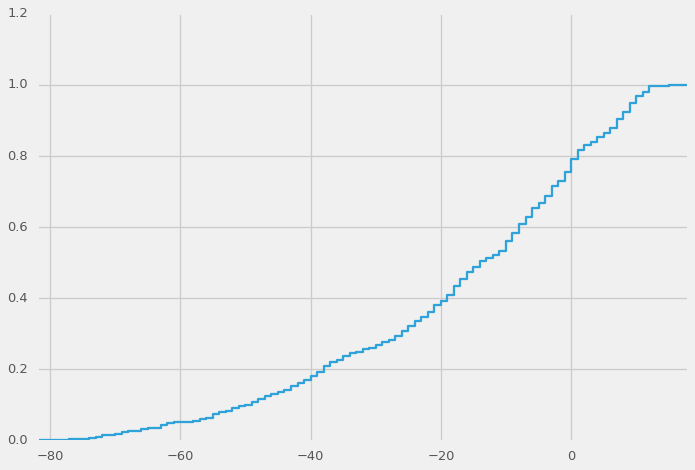

In [116]:
a.value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps')

# <font color="#E56717">Not all patients are in the MEdpar file, but all are in the NCH file concatenated with the OUTSAF file; we can perform a paired test to see if there are statistically significant differences after getting the analog of total_amt for those two files and concatenating with this medpar result</font>


# For now, let's just look at the CDFs of the tot_amt grouped for each patient (a patient may have more than one stay). Do the same for 'los': length of stay in days

In [117]:
dgmedpartreatmentgroup = dgtreatmentgoodclaims.groupby('patient_id')

In [118]:
dgmedparcontrolgroup = dgcontrolgoodclaims.groupby('patient_id')